### Attempt 1: Change the model

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

/home/miellilas/Documents/pba/myanimelist/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(r"../data/processed/top_150_fantasy_reviews_cleaned_balanced.csv")
print(df.head())
print(df["recommendation"].value_counts())

   review_id        anime_title  \
0     503754  Sousou no Frieren   
1     519189  Sousou no Frieren   
2     506314  Sousou no Frieren   
3     506301  Sousou no Frieren   
4     507559  Sousou no Frieren   

                                      review_url                   date  \
0  https://myanimelist.net/reviews.php?id=503754   Oct 13, 2023 8:38 AM   
1  https://myanimelist.net/reviews.php?id=519189  Mar 22, 2024 12:40 PM   
2  https://myanimelist.net/reviews.php?id=506314   Nov 10, 2023 3:29 PM   
3  https://myanimelist.net/reviews.php?id=506301   Nov 10, 2023 9:52 AM   
4  https://myanimelist.net/reviews.php?id=507559   Nov 25, 2023 3:17 PM   

      username  user_review_count  is_preliminary episodes_watched  \
0       Czekaj                  5            True             5/28   
1      chekkit                 25           False              NaN   
2    Hallideus                  3            True            10/28   
3     Gamer651                  9            True         

In [5]:
df[['rating', 'recommendation']].sample(20)

,rating,recommendation
1805,9,Recommended
2965,5,Mixed Feelings
1698,10,Recommended
2993,6,Mixed Feelings
4425,10,Recommended
3621,6,Mixed Feelings
2067,9,Recommended
1402,9,Recommended
771,7,Not Recommended
4760,8,Recommended


In [13]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    max_length=512,
    truncation=True,
    padding=True
)

Device set to use cuda:0


In [14]:
# Function to get sentiment result
def get_sentiment(text):
    try:
        result = sentiment_pipeline(text)[0]
        return pd.Series({
            "label": result['label'],
            "score": result['score']
        })
    except Exception as e:
        return pd.Series({
            "label": "error",
            "score": 0.0
        })

label_map = {
    'LABEL_0': 'negative',
    'LABEL_1': 'neutral',
    'LABEL_2': 'positive'
}

sentiment_results = df['review_sentiment'].apply(get_sentiment)
sentiment_results['label'] = sentiment_results['label'].map(label_map)

df[['roberta_label', 'roberta_score']] = sentiment_results

print(df[['review_sentiment', 'roberta_label', 'roberta_score']].head())

                                    review_sentiment roberta_label  \
0  with lives so short why do we even bother? to ...       neutral   
1  i feel so catered to it feels like an eternity...      positive   
2  i feel some of the other reviews say it all to...      positive   
3  it is been 3 years since i last wrote up a rev...      positive   
4  first time i felt compelled to write a review ...      positive   

   roberta_score  
0       0.643454  
1       0.620097  
2       0.916868  
3       0.937562  
4       0.991244  


In [15]:
df['roberta_label'].value_counts()

roberta_label
positive    2180
negative    1539
neutral     1141
Name: count, dtype: int64

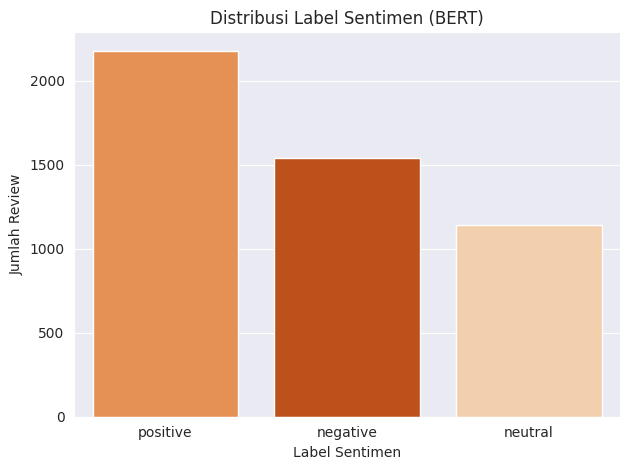

In [16]:
sns.countplot(data=df, x='roberta_label', order=['positive', 'negative', 'neutral'], palette='Oranges', hue='roberta_label')
plt.title('Distribusi Label Sentimen (BERT)')
plt.xlabel('Label Sentimen')
plt.ylabel('Jumlah Review')
plt.tight_layout()
plt.show()

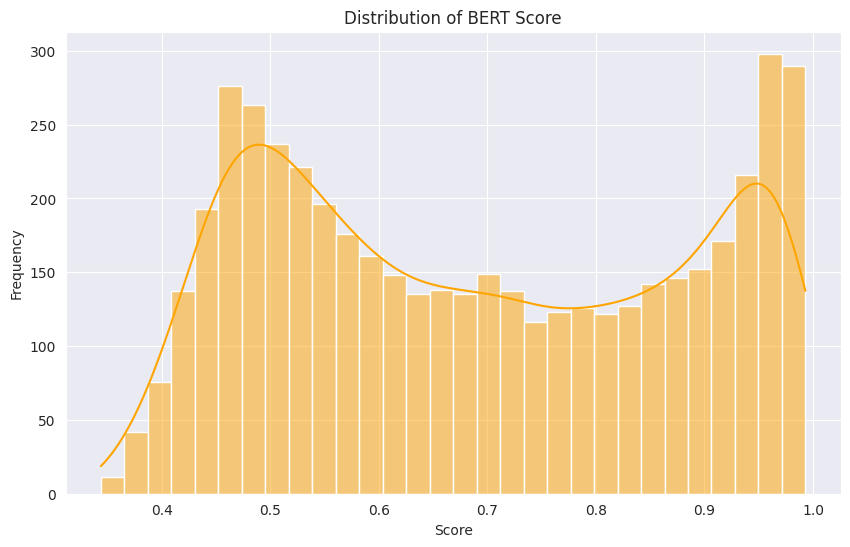

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(df['roberta_score'], bins=30, kde=True, color='orange')
plt.title('Distribution of BERT Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

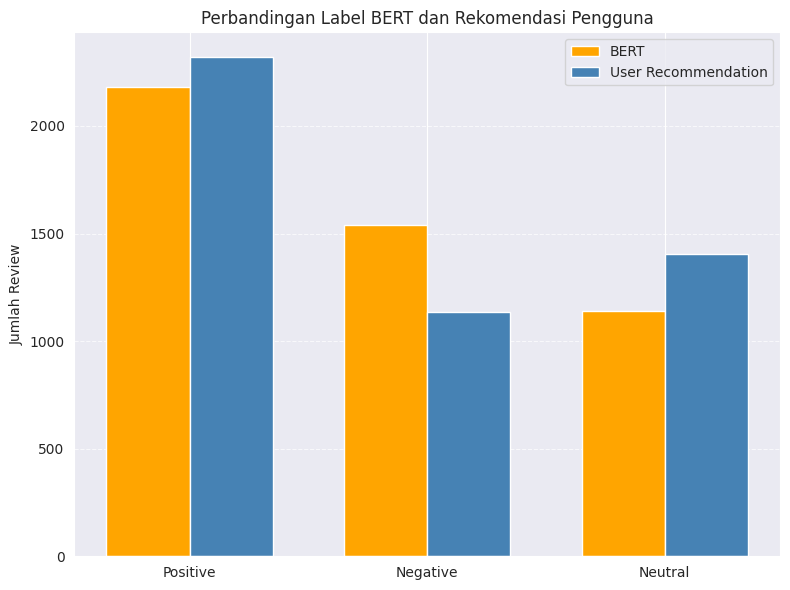

In [18]:
categories = ['positive', 'negative', 'neutral']
matched_recommendations = ['Recommended', 'Not Recommended', 'Mixed Feelings']

vader_counts = [df[df['roberta_label'] == cat].shape[0] for cat in categories]
recommendation_counts = [
    df[df['recommendation'] == rec].shape[0] for rec in matched_recommendations
]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

bars1 = ax.bar(x - width/2, vader_counts, width, label='BERT', color='#FFA500')  # Orange
bars2 = ax.bar(x + width/2, recommendation_counts, width, label='User Recommendation', color='#4682B4')  # Steel Blue

ax.set_ylabel('Jumlah Review')
ax.set_title('Perbandingan Label BERT dan Rekomendasi Pengguna')
ax.set_xticks(x)
ax.set_xticklabels(['Positive', 'Negative', 'Neutral'])
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [19]:
def map_recommendation(rec):
    if rec == 'Recommended':
        return 'positive'
    elif rec == 'Not Recommended':
        return 'negative'
    else:
        return 'neutral'

df['recommendation_mapped'] = df['recommendation'].apply(map_recommendation)

print("=== Evaluation for BERT ===")
print(classification_report(df['recommendation_mapped'], df['roberta_label'], digits=3))

=== Evaluation for BERT ===
              precision    recall  f1-score   support

    negative      0.556     0.754     0.640      1136
     neutral      0.403     0.327     0.361      1405
    positive      0.807     0.759     0.782      2319

    accuracy                          0.633      4860
   macro avg      0.589     0.613     0.594      4860
weighted avg      0.632     0.633     0.627      4860



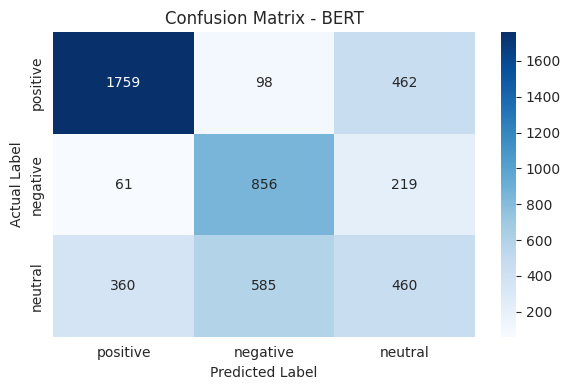

In [20]:
label_map = {
    'Recommended': 'positive',
    'Not Recommended': 'negative',
    'Mixed Feelings': 'neutral'
}

df['recommendation_sentiment'] = df['recommendation'].map(label_map)

cm_bert = confusion_matrix(df['recommendation_sentiment'], df['roberta_label'], labels=['positive', 'negative', 'neutral'])

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['positive', 'negative', 'neutral'],
                yticklabels=['positive', 'negative', 'neutral'])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm_bert, "Confusion Matrix - BERT")

### Attempt 2: Fine Tuning

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import pandas as pd

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['recommendation'])  # 0 = negative, 1 = neutral, 2 = positive

# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['review_sentiment', 'label']])
test_dataset = Dataset.from_pandas(test_df[['review_sentiment', 'label']])

In [10]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "distilbert-base-uncased"  # <- Correct name

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(
        example["review_sentiment"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


/home/miellilas/Documents/pba/myanimelist/venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 972/972 [00:00<00:00, 3045.41 examples/s]


In [11]:
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

training_args = TrainingArguments(
    output_dir="../results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    no_cuda=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)


/home/miellilas/Documents/pba/myanimelist/venv/lib/python3.12/site-packages/transformers/training_args.py:1453: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [12]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1_macro": f1_score(labels, predictions, average="macro")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


In [13]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.679031,0.689300,0.645569


TrainOutput(global_step=486, training_loss=0.7738264421376672, metrics={'train_runtime': 3077.5649, 'train_samples_per_second': 1.263, 'train_steps_per_second': 0.158, 'total_flos': 515042430861312.0, 'train_loss': 0.7738264421376672, 'epoch': 1.0})

In [14]:
trainer.evaluate()


{'eval_loss': 0.6790305376052856,
 'eval_accuracy': 0.6893004115226338,
 'eval_f1_macro': 0.6455688867412323,
 'eval_runtime': 153.3602,
 'eval_samples_per_second': 6.338,
 'eval_steps_per_second': 0.796,
 'epoch': 1.0}

In [15]:
from sklearn.metrics import classification_report

# Step 1: Make predictions using your Trainer
predictions = trainer.predict(test_dataset)

# Step 2: Get predicted labels (the class with the highest score)
preds = predictions.predictions.argmax(-1)

# Step 3: Get true labels from the dataset
labels = predictions.label_ids

# Step 4: Print detailed classification report
print(classification_report(labels, preds, target_names=['negative', 'neutral', 'positive']))


              precision    recall  f1-score   support

    negative       0.50      0.47      0.49       281
     neutral       0.64      0.59      0.61       227
    positive       0.81      0.87      0.84       464

    accuracy                           0.69       972
   macro avg       0.65      0.64      0.65       972
weighted avg       0.68      0.69      0.68       972

